## Se importan las librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
from math import sqrt
import time
#from numba import njit, jit

## Se importan los datos

In [2]:
nombre = '/home/kav/Escritorio/datos/ser800v.csv'

imagen = f'{nombre}.png'
#nombre_pedestal = '/content/drive/MyDrive/a/14juniopedestal_003.csv'
#imagen_pedestal = '14juniopedestal_003.png'

Se importa el archivo csv

In [3]:
df = pd.read_csv(nombre, header = None,)
df[0:12]

/tmp/ipykernel_6288/1082061756.py:1: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(nombre, header = None,)


0               1
0                Model           MSO44
1        Waveform Type          ANALOG
2     Horizontal Units               s
3      Sample Interval  8.00000000e-11
4        Record Length            1250
5           Zero Index     -1.00000000
6       Vertical Units               V
7      FastFrame Count            5000
8     ANALOG_Thumbnail             NaN
9         interpFactor               2
10  realDataStartIndex               1
11                TIME             CH1

Se obtiene la cantidad de datos por cada una de las señales

In [4]:
datos_por_pulso = int(df[1][4])
datos_por_pulso

1250

Se vuelve a importar el csv, pero solo considerando los datos de tiempo y voltaje

In [5]:
df = pd.read_csv(nombre, sep = ',', header = None,
                skiprows = [0,1,2,3,4,5,6,7,8,9,10,11,12], #No se importan las filas 0 a 10
                 names = ['tiempo', 'voltaje'], #Se le agrega un nombre a cada columna
                 dtype = np.float64) #Se elige el tipo de dato para importar los datos, 
    #para este caso usamos float64 ya que este tipo de dato es decimal y puede alcanzar grandes números
    #el  número máximo que puede alcanzar es 2⁶⁴ - 1.

In [6]:
df

tiempo   voltaje
0        4.000000e-11  0.000383
1        1.200000e-10  0.000138
2        2.000000e-10  0.000006
3        2.800000e-10  0.000136
4        3.600000e-10  0.000395
...               ...       ...
6249995  9.963500e-08  0.000061
6249996  9.971500e-08 -0.000033
6249997  9.979500e-08 -0.000059
6249998  9.987500e-08  0.000014
6249999  9.995500e-08  0.000044

[6250000 rows x 2 columns]

Se transforman las columnas del DataFrame de pandas a arreglos de numpy

In [7]:
t = np.array(df['tiempo'].to_numpy())  # convertimos las columnas en arreglos de numpy
v = np.array(df['voltaje'].to_numpy())

Se revisa si hay elementos datos NaN (not a number) o valores infinitos, o si hay valores máximos que se repitan muchas veces, debido a que si se repiten muchas veces puede que se deba a una saturación

In [8]:
df.isnull().values.any() #comprobar si hay variables NaN en el dataframe

False

In [9]:
# Conocer el valor máximo de voltaje y las veces que se repite este valor
print("El valor máximo de voltaje es: ", v.min())
print("Las veces que se repite este valor es: ",list(v).count(min(v)))
#print(list(v).index(v.min()))
#print(list(y).count(0.0323125))

El valor máximo de voltaje es:  -0.0064765625
Las veces que se repite este valor es:  1



Se cuenta la cantidad de pulsos que hay en el archivo:

In [10]:
filas = len(t) #cantidad de filas que tiene la columna de tiempo
numero = filas/datos_por_pulso # Variable numero: cantidad de pulsos
print("La cantidad de pulsos es :", numero)

La cantidad de pulsos es : 5000.0


#### Se grafica una medición para revisar que esté todo en orden

In [49]:
figure(figsize=(16, 9), dpi=800)
n = 336 # número del pulso que se quiere graficar
plt.plot(t[datos_por_pulso*n:datos_por_pulso*n+datos_por_pulso],
         v[datos_por_pulso*n:datos_por_pulso*n+datos_por_pulso]) #el valor de la izquierda a indica donde comienza la lista y el lado derecho donde termina

plt.ylabel('Voltaje [V]') # Títulos de los ejes.
plt.xlabel('Tiempo [s]')

plt.title('Gráfico de la muestra') #Título del gráfico
plt.show()

## Cálculo offset, para realizar corrección de offset

Se establecen los números que serán los índices en los cuales se harán los cortes para calcular el offset

In [12]:
inf = int(datos_por_pulso*0.25) #Corte por izquierda, por ejemplo si son 1000 datos por pulso, se cortará en el dato 250
sup = int(datos_por_pulso*0.75) #Corte por derecha, si son 1000 datos por pulso, cortará en el dato 750

Función para crear 3 arreglos de numpy a partir de 1 pulso, en el caso de que fuesen 1000 datos por pulso, el primer arreglo contrendría los datos de 0 a 250, el segundo los datos de 750 a 1000, y el último tomaría todos los datos, es decir, de 0 a 1000.

In [13]:
def seccionar(v, i,inf,sup):
    indice_0 = datos_por_pulso*i
    indice_menor = (datos_por_pulso * i) + inf
    indice_mayor = (datos_por_pulso * i) + sup
    indice_final = (datos_por_pulso * i) + datos_por_pulso
    
    lista_izq = v[indice_0:indice_menor]
    lista_der = v[indice_mayor:indice_final]
    lista_completa = v[indice_0:indice_final]
    
    return lista_izq, lista_der, lista_completa

Se crea una función que realizará una resta entre la lista completa y una lista de igual dimensión, utilizando el valor de offset

In [14]:
def offset(lista_completa, vo, menosoff):
    return lista_completa - vo*menosoff


Se define la función principal, donde se conectarán las funciones definidas arriba, el objetivo principal de esta función es calcular el valor de offset de cada una de las señales, y restar este valor a cada uno de los datos, de este modo se obtendrá una señal más centrada en 0 V.

In [15]:
def voltaje_corregido(v, numero):
    
    menosoff = np.asfarray([1 for x in range(datos_por_pulso)])
    VV = np.asfarray([], np.float64)
    Vrms = np.asfarray([], np.float64)
    Voff = np.asfarray([], np.float64)
    
    for i in range(int(numero)):
        
        lista_izq, lista_der, lista_completa = seccionar(v, i,inf,sup)
        
  
        vo_izq = sum(lista_izq)/len(lista_izq)
        vo_der = sum(lista_der)/len(lista_der)
        vo_completa = sum(lista_completa)/len(lista_completa)
        if min(lista_completa) < - 0.002:
            if abs(vo_izq) < abs(vo_der):

                Voff = np.append(Voff, vo_izq)
                VV = np.concatenate((VV, offset(lista_completa, vo_izq, menosoff)))
            else:

                Voff = np.append(Voff, vo_izq)
                VV = np.concatenate((VV, offset(lista_completa, vo_izq, menosoff)))
        else:
            Voff = np.append(Voff,vo_completa)
            VV = np.concatenate((VV, offset(lista_completa, vo_completa, menosoff)))
    return VV, Vrms, Voff

Se aplica la función de offset, y se calcula el tiempo que tarda en realizarse, además se toma el tiempo que demora en realizarse, esto último lo añadí debido a que se corrigió el programa ara que fuese más eficiente, antes el programa demoraba 30 veces más de lo que se demora ahora.

In [16]:

tiempo_inicial = time.time()
v, Vrms, Voff = voltaje_corregido(v, numero)

tiempo_final = time.time() - tiempo_inicial

In [17]:
print(tiempo_final) # cuánto tardó el programa en ejecutarse

20.375391483306885


### Comparación offset viejo y offset nuevo

Se vuelve a calcula el offset para corroborar si fue aplicado correctamente

In [18]:
#Se calcula nuevamente el offset, pero de los datos corregidos, y con esto comparar el offset viejo con el nuevo
def voltaje_offset(v, numero):
    menosoff = np.asfarray([1 for x in range(datos_por_pulso)])
    VV = np.asfarray([], np.float64)
    Vrms = np.asfarray([], np.float64)
    Voff = np.asfarray([], np.float64)
    
    for i in range(int(numero)):
        
        lista_izq, lista_der, lista_completa = seccionar(v, i,inf,sup)
        
  
        vo_izq = sum(lista_izq)/len(lista_izq)
        vo_der = sum(lista_der)/len(lista_der)
        vo_completa = sum(lista_completa)/len(lista_completa)
        if min(lista_completa) < - 0.02:
            if abs(vo_izq) < abs(vo_der):

                Voff = np.append(Voff, vo_izq)
            #    VV = np.concatenate((VV, offset(lista_completa, vo_izq, menosoff)))
            else:

                Voff = np.append(Voff, vo_izq)
            #    VV = np.concatenate((VV, offset(lista_completa, vo_der, menosoff)))
        else:
            Voff = np.append(Voff,vo_completa)
            #VV = np.concatenate((VV, offset(lista_completa, vo_completa, menosoff)))
    return Voff

In [19]:
nuevoOffset = voltaje_offset(v,numero)

In [20]:
eq = range(0,int(numero)) #Se crea una lista para el eje x del gráfico
figure(figsize=(16, 9), dpi=800) #Se define el tamaño del gráfico


plt.scatter(eq, Voff, s = 4, color = 'blue', label = 'Offset')
plt.scatter(eq, nuevoOffset, s = 4, color = 'green', label = 'Nuevo offset')
#plt.plot(t2, listaPromRMS, color = 'k', lw = 3, ls = '--', label = 'Promedio RMS')
#plt.ylim(-1,1)
#plt.xlim(10,40)
plt.xlabel("Número de pulso")
plt.ylabel("Valor de offset")
plt.title("Comparación offset y nuevo offset")
plt.legend()
plt.grid()
plt.show()

##### Se busca la señal con el valor de voltaje más alto

In [22]:
v = list(v)
print(v.index(min(v))/datos_por_pulso)
pulso_maximo = v.index(min(v))/datos_por_pulso # indica el pulso donde se encuentra el peak máximo de voltaje

1137.6976


Se grafica la señal de pulso más alto

In [50]:
#el valor izquierda a indica donde comienza la lista y el valor derecha donde termina
#el valor npulso, el número da cada pulso

izquierda = 0 # izquierda y derecha indican los índices que consideraremos para calcular las integrales
derecha = datos_por_pulso # Cambiar valores de izquierda y derecha por si se requiere acotar el pulso
npulso = int(pulso_maximo)

In [51]:
#Se grafica con los indices ingresados
%matplotlib inline
figure(figsize=(16, 9), dpi=800)
plt.plot(t[datos_por_pulso*npulso + izquierda : datos_por_pulso*npulso + derecha] , 
         v[datos_por_pulso*npulso + izquierda : datos_por_pulso*npulso + derecha])
plt.ylabel('Voltaje [V]') 
plt.xlabel('Tiempo [s]')

plt.title('Gráfico de la muestra') 
plt.show()

#### Se calcula el valor de la carga de cada una de las señales

$ \frac{dQ}{dt} = I$ 

$ I = \frac{V}{R} $

$ Q = \int \frac{V}{R}\cdot dt $

Para esto se realiza una suma de Riemann en el gráfico de voltaje vs tiempo, y luego se divide el valor encontrado por 50, que es el valor de la resistencia de salida del PMT.

In [52]:
integrales = []  #lista que contiene los valores de cada integral
for i in range(int(numero)):
    #Para indexar se utiliza xx e yy
    
    corte_izq = datos_por_pulso * i + izquierda
    corte_der = (datos_por_pulso * i) + derecha
    izq_completa = (datos_por_pulso * i )
    der_completa = (datos_por_pulso * i ) + datos_por_pulso
    
    #tiempos = list(t[xx:yy]) # yss y xss son las listas indexadas a la cual se le calculará la integral
    voltajes_cortados = list(v[corte_izq:corte_der])
    voltajes_completos = list(v[izq_completa: der_completa])
    tiempo = t[1] - t[0]
    #print(tiempo)
    
    #if min(yss) < -0.004:
    integrales.append(-1*(sum(voltajes_cortados)*tiempo/50))
    #else:
    #integrales.append(-1*(sum(voltajes_completos)*tiempo/50))

#### Histograma utilizando matplotlib

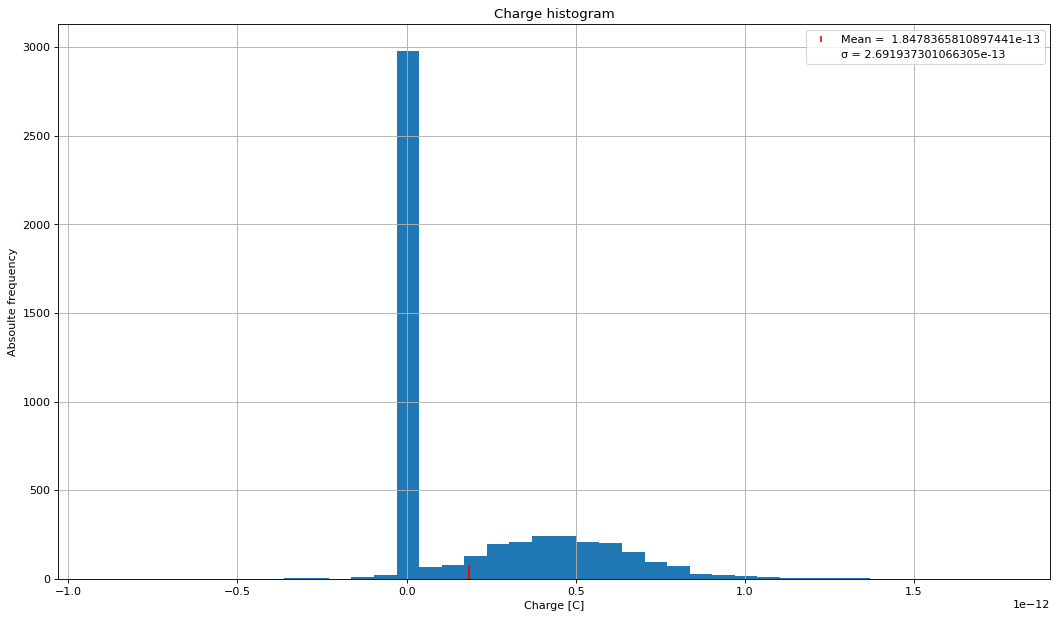

In [53]:
%matplotlib inline
figure(figsize=(16, 9), dpi=80)

histograma_integrales = plt.hist(integrales, bins = 40)
plt.ylabel('Absoulte frequency')
plt.xlabel('Charge [C]')
#plt.xlim(0,0.5*10**(-12))
media1 = [np.mean(integrales) for x in range(60)]
vay1 = [x for x in range(0, 60)]

plt.scatter(media1, vay1, c = 'red', marker = '|', label = f"Mean =  {np.mean(integrales)}")
plt.plot([], [], ' ', label=f"σ = {np.std(integrales)}")
plt.grid()
plt.legend()
plt.title("Charge histogram")
plt.savefig(imagen, facecolor = 'lavender')
plt.show()

### Histograma utilizando ROOT

In [54]:
# Importar esta libreria si se quiere trabajar con root
import ROOT
from ROOT import TCanvas, TFile, TPaveText
from ROOT import gROOT, gBenchmark


In [55]:
%jsroot on

In [56]:
c1 = ROOT.TCanvas("c1","Histograma root",800,600)
hist = ROOT.TH1D("integrales","Histrogram of the charge",
                 40, min(integrales)-np.std(integrales), max(integrales)+np.std(integrales))
for i in range(len(integrales)):
    hist.Fill(integrales[i])

hist.GetYaxis().SetTitle('#Deltan / #Deltaq')
hist.GetXaxis().SetTitle('Carga [C]')
g1 = ROOT.TF1("g1", "gaus", -2.24*10**-13, 2.2*10**-13)
g2 = ROOT.TF1("g2", "gaus", 1.0319*10**-13, 1.247*10**-12)

#c1.SetLogy()
hist.SetFillColor(0)
hist.Fit('g1', "R")
hist.Fit('g2', "R+")
#hist.Fit('g3', "R+","")


hist.Draw("R+")
c1.Draw()

 FCN=123.999 FROM MIGRAD    STATUS=CONVERGED      99 CALLS         100 TOTAL
                     EDM=1.70959e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.02765e+03   5.90120e+01   2.98007e-01  -6.53707e-06
   2  Mean         8.95617e-16   1.03825e-15   5.10819e-18   5.66474e+11
   3  Sigma        2.74237e-14   3.79159e-16   2.05210e-05   4.65980e-02
 FCN=20.1263 FROM MIGRAD    STATUS=CONVERGED      67 CALLS          68 TOTAL
                     EDM=3.19643e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.89802e+02   8.72323e+00   1.49912e-02  -3.43786e-05
   2  Mean         4.42065e-13   6.72562e-15   1.30992e-17   6.34353e+09
   3  Sigma        2.23665e-13   

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: integrales (Potential memory leak).


### Cálculo de la ganancia

Se cuenta la cantidad de datos en el pedestal

In [62]:
indices_noceros = [x for x in integrales if x > 1.162e-13]
indices_ceros = [ x for x in integrales if x < 1.162e-13]
print(len(indices_noceros), len(indices_ceros))

1911 3089


#### Cálculo de $\mu$ utilizando distribución de Poisson

Para calcular $\mu$ se utiliza la siguiente ecuación derivada de la ecuación de la distribución de Poisson

$\mu = -ln(\frac{N_0}{N_{tot}})$

Donde $N_0$ son el número de datos en el pedestal, y $N_{tot}$ son el número de datos totales del histograma

In [63]:
from math import log
mu = -log(len(indices_ceros)/len(integrales))
mu

0.4815904984976557

Se definen las siguientes variables, mean y sigma son obtenidas de los fits realizados al histograma en ROOT.

In [64]:
mean = 4.42065e-13
sigma = 2.23665e-13
carga_electron = 1.602e-19

In [68]:
#mu1 = mean**2 / sigma ** 2
#mu1

Finalmente, se encuentra la ganancia del PMT

In [67]:
format(mean / (carga_electron ), ' .3E')

' 2.759E+06'

### Animación de las señales

In [79]:
señales = [integrales.index(x) for x in integrales if x > 10e-13]

In [83]:
#señales

In [84]:
len(señales)

39

<IPython.core.display.Javascript object>


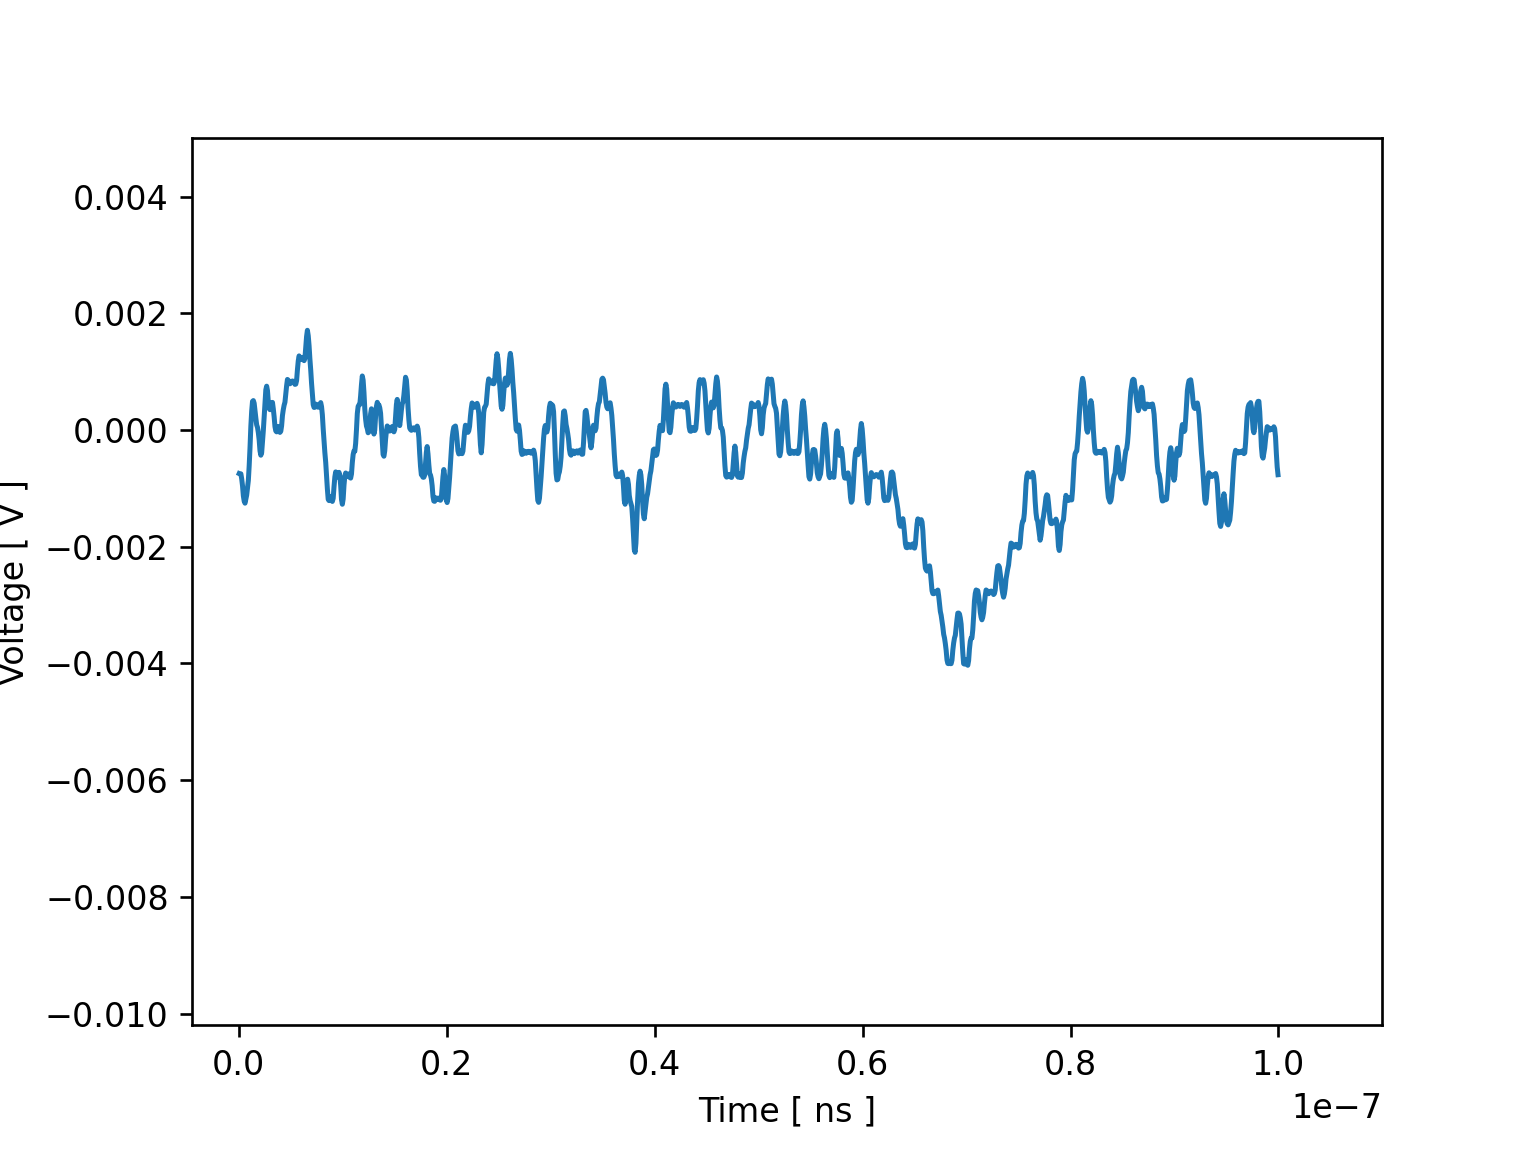

In [82]:
%matplotlib notebook
import matplotlib.animation as ani
from matplotlib.animation import FuncAnimation, PillowWriter
###print(x)
##print(len(VV))
##tie = list(t)
##vol = list(v)
#figure(figsize=(16, 9), dpi=80)

figu, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [])

def init():
    ax.set_xlim(-0.045*10**(-7),1.1*10**(-7) )
    ax.set_ylim(-0.0102, 0.00500)
    ax.set_xlabel('Time [ ns ]')
    ax.set_ylabel('Voltage [ V ]')
   # ax.grid()
#  #   ax.grid(True)
    return ln,

def update(frame):
    

    xdata = t[frame*datos_por_pulso+izquierda:frame*datos_por_pulso+derecha]#datos_por_pulso]
    ydata = v[frame*datos_por_pulso+izquierda:frame*datos_por_pulso+derecha]#datos_por_pulso]
    
    ln.set_data(xdata[:],ydata[:])
    return ln,

ani = FuncAnimation(figu, update, frames= señales,
                     init_func=init, blit=True, interval = 1000, save_count= 500)
ani.save('ser800vseñales.gif', writer=PillowWriter(fps=3))
#
plt.show()

In [85]:

#prob_darkpulse = #probabilidad obtenida desde el datasheet del pmt utilizado
#def background():
    

In [86]:
#from math import exp
#def Ser():
#    (PE/2*A) * exp( ( phi_p**2-2*A(x-xp) ) / (2*A**2) ) * (1 + Erf (A, xp, phi_p))

#def Erf(A, xp, phi_p):
    